In [2]:
import random
import json
import asyncio

import pandas as pd
from collections import defaultdict
from datasets import load_dataset
from tqdm.asyncio import tqdm_asyncio
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from predictors import *
from llm import *
from prompts import *
from tools import *
from evaluations import *

BIG_MODEL = "gpt-4.1"
MEDIUM_MODEL = "gpt-4.1-mini"
SMALL_MODEL = "gpt-4.1-nano"

MODELS = [SMALL_MODEL, MEDIUM_MODEL, BIG_MODEL]
model_to_idx = {name: i for i, name in enumerate(MODELS)}

In [3]:
with open('./data/mixture_dataset_naive.pkl', 'rb') as f:
    all_results = pickle.load(f)

In [4]:
benchmark_results = [{'model': 'gpt-4.1',
'output_tokens': 2635,
'elapsed_sec': 58.7119711250125,
'speed_tokens_per_sec': 44.88011472804115},
{'model': 'gpt-4.1-mini',
'output_tokens': 1642,
'elapsed_sec': 17.52961220900761,
'speed_tokens_per_sec': 93.6700698465113},
{'model': 'gpt-4.1-nano',
'output_tokens': 2102,
'elapsed_sec': 9.232372332990053,
'speed_tokens_per_sec': 227.67712611512857}]

# Function to extract validation pass rates for each model
def get_validation_pass_rates():
    model_pass_rates = {}
    for result in all_results:
        if result['dataset'] == 'valid':  # Focus on validation set
            model_name = result['model']
            pass_rate = result['metrics']['pass_rate']
            model_pass_rates[model_name] = pass_rate
    return model_pass_rates

# Function to extract speeds from benchmark results
def get_model_speeds():
    model_speeds = {}
    for result in benchmark_results:
        model_name = result['model']
        speed = result['speed_tokens_per_sec']
        model_speeds[model_name] = speed
    return model_speeds

# Get the data
pass_rates = get_validation_pass_rates()
speeds = get_model_speeds()

pass_rates, speeds

({'gpt-4.1-nano': 57.20476706392199,
  'gpt-4.1-mini': 74.21451787648971,
  'gpt-4.1': 78.9815817984832},
 {'gpt-4.1': 44.88011472804115,
  'gpt-4.1-mini': 93.6700698465113,
  'gpt-4.1-nano': 227.67712611512857})

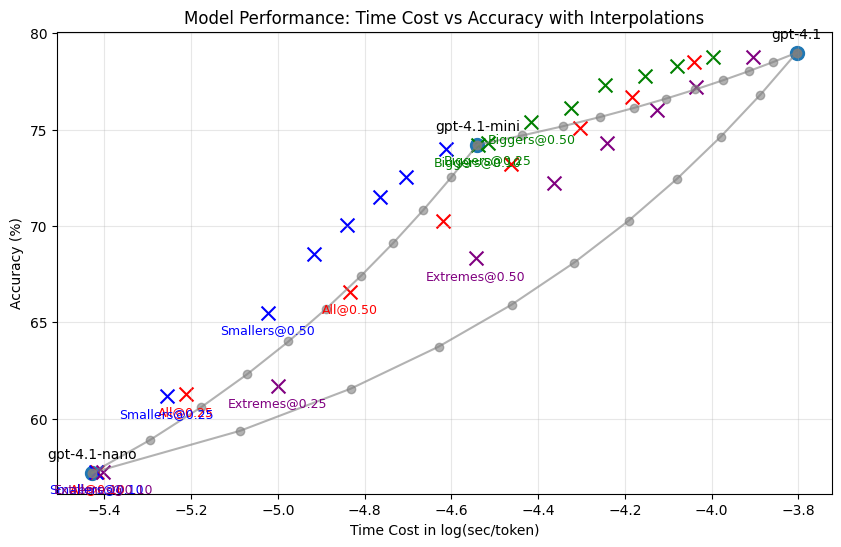

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use all models (assumed to be 3)
models = list(pass_rates.keys())
pass_rate_values = [pass_rates[model] for model in models]
speed_values = [speeds[model] for model in models]
time_cost_values = [1/speeds[model] for model in models]
log_time_cost_values = [np.log(s) for s in time_cost_values]

# Create the base plot
plt.figure(figsize=(10, 6))
plt.scatter(log_time_cost_values, pass_rate_values, s=100)

# Add model labels
for i, model in enumerate(models):
    plt.annotate(model, (log_time_cost_values[i], pass_rate_values[i]),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center')

# Parametric interpolation between every pair of distinct points
t_values = np.linspace(0, 1, 11)

for i in range(len(models)):
    for j in range(i + 1, len(models)):
        x0, x1 = time_cost_values[i], time_cost_values[j]
        y0, y1 = pass_rate_values[i], pass_rate_values[j]
        
        interp_x = [(1 - t) * x0 + t * x1 for t in t_values]
        log_interp_x = [np.log(x) for x in interp_x]
        interp_y = [(1 - t) * y0 + t * y1 for t in t_values]
        
        plt.plot(log_interp_x, interp_y, linestyle='-', marker='o', color='gray', alpha=0.6)


# ---------------------- NEW CODE: Add strategy points ----------------------
from itertools import cycle

thresholds = [0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

strategy_tags = {
    'All': MODELS,
    'Smallers': [SMALL_MODEL, MEDIUM_MODEL],
    'Biggers': [MEDIUM_MODEL, BIG_MODEL],
    'Extremes': [SMALL_MODEL, BIG_MODEL],
}

colors = {
    'All': 'red',
    'Smallers': 'blue',
    'Biggers': 'green',
    'Extremes': 'purple'
}
markers = cycle(['x'])  # one marker per strategy

for strategy_name, marker in zip(strategy_tags.keys(), markers):
    for t in thresholds:
        acc = df_valid[f'correct@{t}@{strategy_name}'].mean() * 100  # % scale
        avg_cost = df_valid[f'cost@{t}@{strategy_name}'].mean()
        log_cost = np.log(avg_cost)

        # Plot strategy-threshold point
        plt.scatter(log_cost, acc, color=colors[strategy_name], s=100, marker=marker)

        # Annotate
        tag = f'{strategy_name}@{t:.2f}' if t < 0.6 else ''
        plt.annotate(tag, (log_cost, acc),
                     textcoords="offset points",
                     xytext=(0, -15),
                     ha='center',
                     color=colors[strategy_name],
                     fontsize=9)
# ---------------------------------------------------------------------------


# Labels and title
plt.xlabel('Time Cost in log(sec/token)')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance: Time Cost vs Accuracy with Interpolations')
plt.grid(True, alpha=0.3)

# Show in notebook
plt.show()


In [20]:
df_valid = pd.read_csv('./data/valid_mixture_knn.csv')